In [40]:
import os
import cv2
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import h5py

In [41]:
hdf5_PATH = os.path.join(os.getcwd(), "data\\garbage_data.hdf5")

with h5py.File(hdf5_PATH, 'r') as hf:
    train_data = hf["train_data"][:]
    train_label = hf["train_label"][:]
    test_data = hf["test_data"][:]
    test_label = hf["test_label"][:]

classes = pd.read_csv("data\\label.csv")

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)
display(classes)

(9000, 224, 224, 3)
(9000,)
(1000, 224, 224, 3)
(1000,)


,label
0,battery
1,biological
2,cardboard
3,clothes
4,glass
5,metal
6,paper
7,plastic
8,shoes
9,trash


In [42]:
def imshow(images, labels, classes):
    plt.figure(figsize=(12, 8))

    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(images[i])
        plt.title(classes["label"][labels[i]]) # DataFrame으로 불러왔기 때문
    plt.show

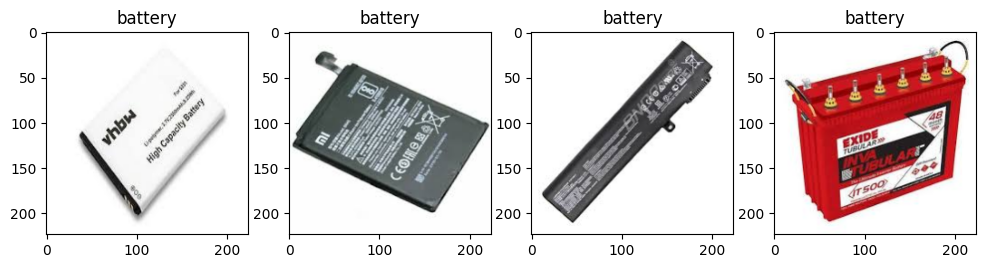

In [43]:
imshow(train_data[:4], train_label[:4], classes)

In [44]:
class CustomImageDataset(Dataset):

    def __init__(self, image, label=None, classes=None, transform=None, target_transform=None, test=False):
        self.image = image
        self.label = label
        self.classes = classes
        self.transform = transform
        self.target_transform = target_transform
        self.test = test

    def __len__(self):
        if not(self.test):
            return len(list(zip(self.image, self.label)))
        else:
            return len(self.image)
        
    def __getitem__(self, idx):
        if not (self.test):
            image = self.image[idx]
            label = self.label[idx]

            if self.transform:
                image = self.transform(image)
            if self.target_transform:
                label = self.target_transform(label)

            return image, label
        else:
            image = self.image[idx]

            if self.transform:
                image = self.transform(image)
            return image

In [45]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, ), (.5, ))
])

In [46]:
train_dataset = CustomImageDataset(
    train_data,
    train_label,
    classes,
    transform=transform,
    test=False
)

test_dataset = CustomImageDataset(
    test_data,
    test_label,
    classes,
    transform=transform,
    test=True
)

In [47]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [48]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 224 -> 112

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 112 -> 56

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 56 -> 28
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 28 -> 14

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 14 -> 7

            nn.Flatten(), # Flatten은 layer로 안쳐준다.
            nn.Dropout(.5),
            nn.Linear(in_features=512*7*7, out_features=4096),
            nn.ReLU(),
            nn.Dropout(.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=10)
        )

    def forward(self, x):
        return self.conv_layer(x)

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [50]:
model = VGG16().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-5)

In [52]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
def train(model, train_dataloader, optimizer):
    model.train()
    correct = 0
    train_loss = 0
    total = len(train_dataloader)